# **Exploratory Data Analysis**

## Objectives

* Write your notebook objective here, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Write down which data or information you need to run the notebook 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Code projects\\final-hackathon\\cybersecurity-intrusion-detection\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Code projects\\final-hackathon\\cybersecurity-intrusion-detection'

# Section 1

Section 1 content

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv('data/processed/cybersecurity_intrusion_data_cleaned.csv')
df.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


---

# Feature Engineering

Section 2 content

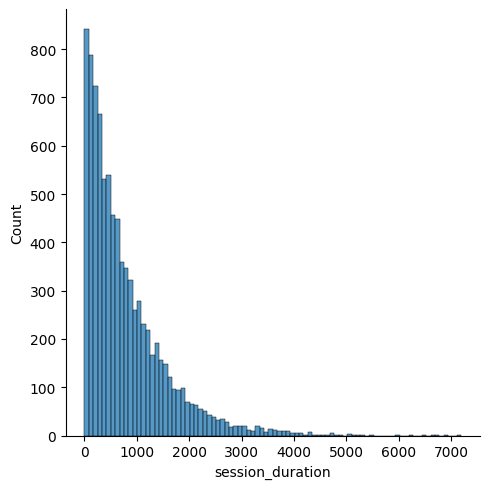

In [6]:
sns.displot(df['session_duration'])
plt.show()

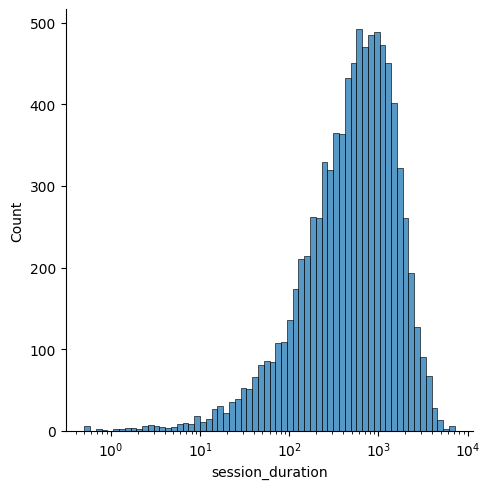

In [7]:
sns.displot(df['session_duration'], log_scale=True)
plt.show()

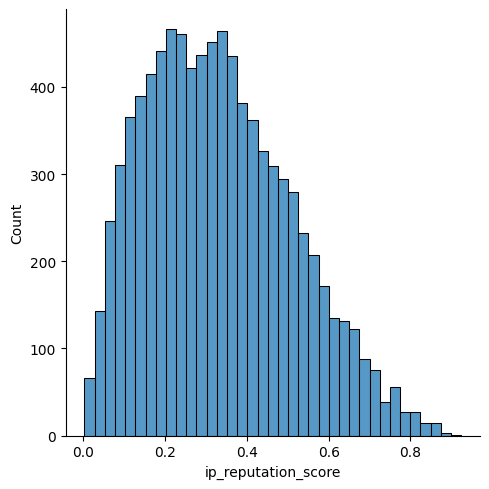

In [8]:
sns.displot(df['ip_reputation_score'])# Base values are more 
plt.show()

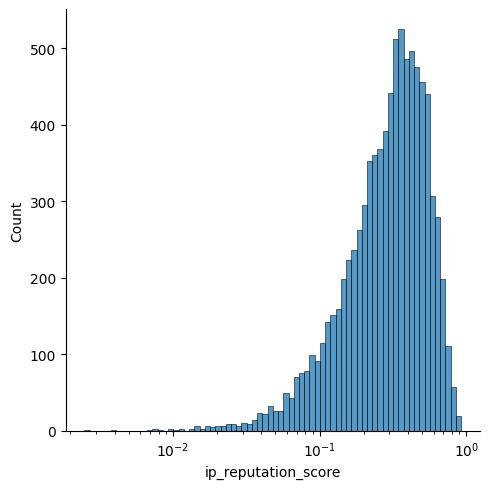

In [9]:
sns.displot(df['ip_reputation_score'], log_scale=True) # Decide to not log transform
plt.show()

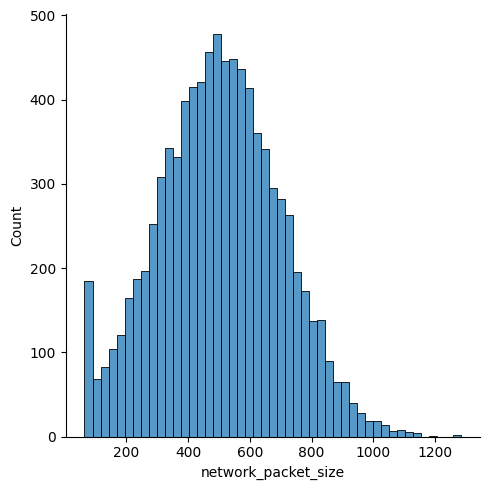

In [10]:
sns.displot(df['network_packet_size'])
plt.show()

In [11]:
(df['network_packet_size'] == 64).sum()

132

In [12]:
df['network_packet_size_is64'] = df['network_packet_size'] == 64
df

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected,network_packet_size_is64
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1,False
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0,False
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1,False
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1,False
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,SID_09533,194,ICMP,3,226.049889,AES,0.517737,3,Chrome,0,1,False
8803,SID_09534,380,TCP,3,182.848475,No encryption,0.408485,0,Chrome,0,0,False
8804,SID_09535,664,TCP,5,35.170248,AES,0.359200,1,Firefox,0,0,False
8805,SID_09536,406,TCP,4,86.664703,AES,0.537417,1,Chrome,1,0,False


In [13]:
(df['network_packet_size_is64'] == True).sum()

132

In [14]:
df['fail_ratio'] = df['failed_logins'] / df['login_attempts']
df

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected,network_packet_size_is64,fail_ratio
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1,False,0.250000
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0,False,0.000000
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1,False,0.666667
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1,False,0.000000
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0,False,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8802,SID_09533,194,ICMP,3,226.049889,AES,0.517737,3,Chrome,0,1,False,1.000000
8803,SID_09534,380,TCP,3,182.848475,No encryption,0.408485,0,Chrome,0,0,False,0.000000
8804,SID_09535,664,TCP,5,35.170248,AES,0.359200,1,Firefox,0,0,False,0.200000
8805,SID_09536,406,TCP,4,86.664703,AES,0.537417,1,Chrome,1,0,False,0.250000


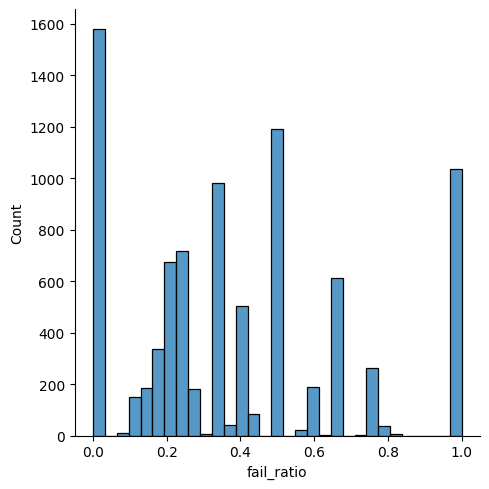

In [15]:
sns.displot(df['fail_ratio'])
plt.show()

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* In cases where you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.